### Recreating Figure 2C from Bloniasz, Oyama, and Stephen (2024)

In [11]:
from filtered_point_process.PointProcess import PointProcessModel
from filtered_point_process.FPP import FilteredPointProcess
from filtered_point_process.visualization import Visualizer

import matplotlib.pyplot as plt
import os
import numpy as np

In [12]:
# Setting Parameters

params = {
    'method': 'gaussian',
    'peak_height': 5000,
    'center_frequency': 1,
    'peak_width': 0.1,
    'fs': 1/0.0001,
    'T': 5,
    'Nsims': 1,
    'lambda_0': [500]
}

model_1 = PointProcessModel(params=params, seed=45)
model_1.simulate_pp()  # Simulate the CIF model for model_1

# Define the filters to be used
filters = {
    'filter_1': 'GABA',
    'filter_2': '1/f'
}

# Instantiate the FilteredPointProcess class with the specified filters and model
fpp = FilteredPointProcess(filters=filters, model=model_1)

/Users/patrick_bloniasz/Documents/GitHub/filtered_point_process/filtered_point_process/PointProcess.py:9: UserWarning: Seed set globally to 45 for reproducibility.
  super()._set_seed(seed)
/Users/patrick_bloniasz/Documents/GitHub/filtered_point_process/filtered_point_process/cif.py:20: UserWarning: Seed set globally to 45 for reproducibility.
  super()._set_seed(seed)
/Users/patrick_bloniasz/Documents/GitHub/filtered_point_process/filtered_point_process/pp.py:25: UserWarning: Seed set globally to 45 for reproducibility.
  super()._set_seed(seed)


In [13]:
# Custom Plotting Parameters for Paper (non-stylized plotting functions are available directly in the package)

cif_copy = np.real(np.abs(fpp.model.cif_realization[5000:25000]))

## Function for "create_spike_train" is a private function in FPP, but is retrieved below for plotting purposes 

create_spike_train_method = getattr(fpp, '_create_spike_train')

spikes_GABA = create_spike_train_method(spike_times = fpp.model.pp_events, time_axis=fpp.model.pp_time_axis, fs=params['fs'])[5000:25000]


In [14]:
## Perform Convolutions to retreive the simulated LFPs. 

convolution_results = fpp.perform_convolutions()

# Retrieve spectra
spectra = fpp.get_spectra()

Notice below that we can see the names of the filters clearly auto-generated to ensure clarity when interacting with various combinations of parameters.

In [15]:
print( convolution_results.keys() )
print( spectra.keys() )

dict_keys(['pp ⨂ GABA', 'pp ⨂ GABA ⨂ 1/f'])
dict_keys(['pp * GABA', 'pp * GABA * 1/f'])


Here, we are using "PSPs" to mean post-synaptic potentials. Note that we also shortten the time axis to 5000:25000 to focus on 2.5 seconds of the simulation after the "burn-in" period which is intrinsic to a filtered point process model. 

In [16]:
sim_PSPs_GABA = convolution_results[list(convolution_results.keys())[0]][5000:25000]
sim_PSPs_GABA_1f = convolution_results[list(convolution_results.keys())[1]][5000:25000]
t = fpp.model.cif_time_axis[5000:25000]

frequencies = fpp.model.cif_frequencies
cif_PSD = fpp.model.cif_PSD
pp_PSD = fpp.model.pp_PSD



# Spectrum after 1st filter
h_spectrum = spectra.get("pp * GABA")

# Spectrum after 2nd filter
final_spectrum = spectra.get("pp * GABA * 1/f")

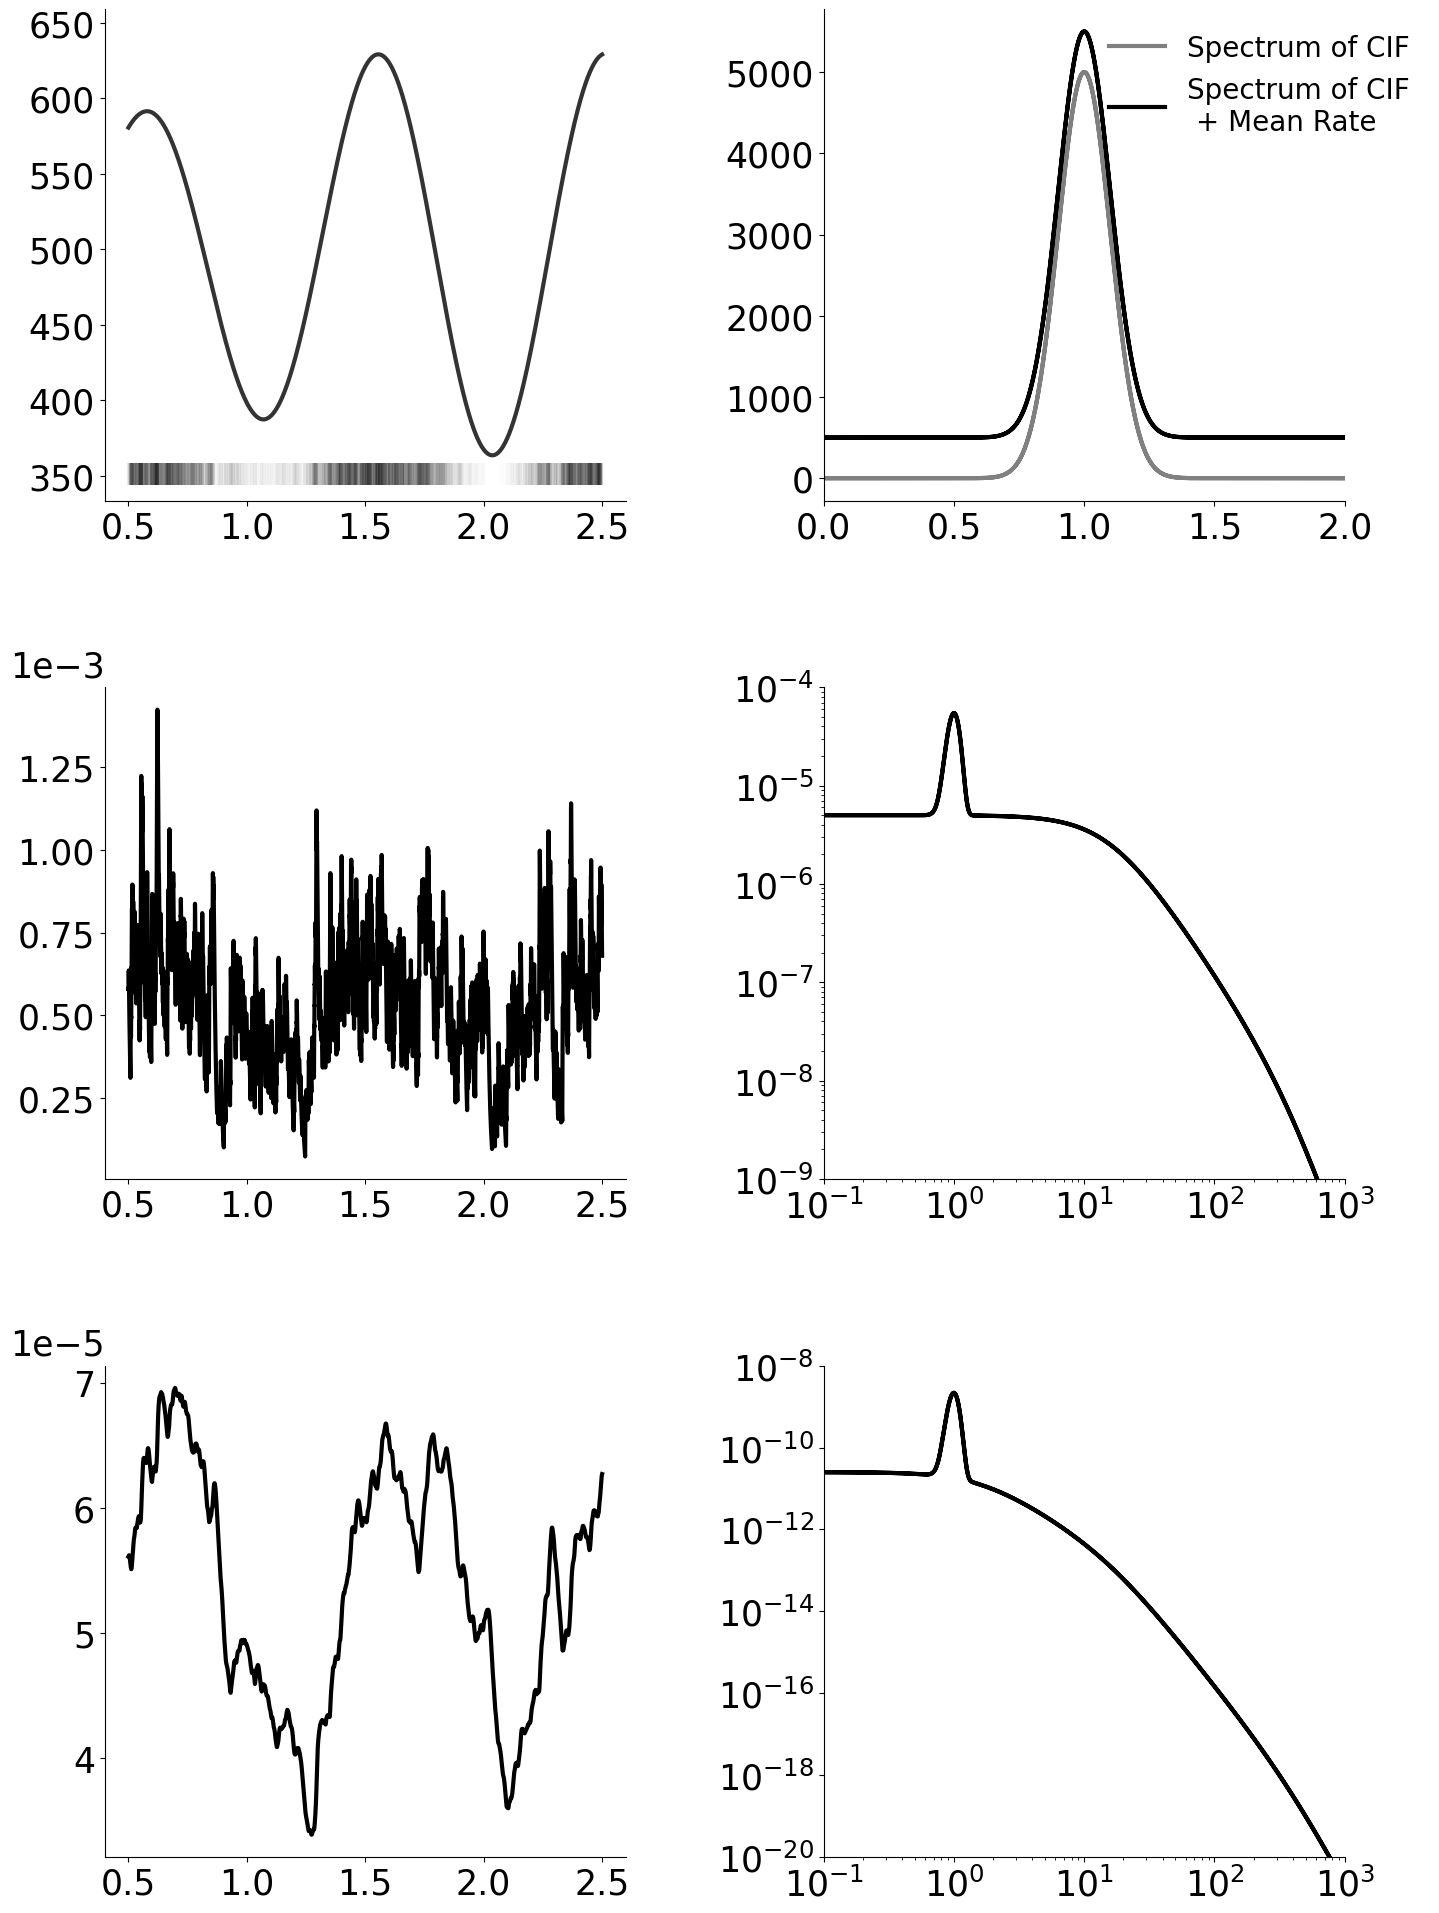

In [17]:
from scipy.signal import find_peaks
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

# Set global defaults for label sizes (optional)
plt.rc('xtick', labelsize=25)  # Set x-tick label size
plt.rc('ytick', labelsize=25)  # Set y-tick label size
plt.rc('axes', labelsize=14)   # Set x and y labels size
plt.rcParams['lines.linewidth'] = 3

# Set up the figure and subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 24)) 

# Plot the CIF on the primary y-axis
axs[0, 0].plot(t, cif_copy, color='black', alpha=0.8)  # Plot the real part of CIF

# Normalize CIF values to [0, 1]
cif_min, cif_max = np.min(cif_copy), np.max(cif_copy)
normalized_cif = (cif_copy - cif_min) / (cif_max - cif_min)

# Map normalized CIF values to desired alpha range
alpha_range_min, alpha_range_max = 0.001, 0.1
scaled_alpha = alpha_range_min + (alpha_range_max - alpha_range_min) * normalized_cif

# Add spike plots with dynamic alpha
spike_indices = np.nonzero(spikes_GABA)[0]
for spike_index in spike_indices:
    spike_time = t[spike_index]
    alpha = scaled_alpha[spike_index]
    axs[0, 0].vlines(spike_time, ymin=cif_min - 20, ymax=cif_min - 5, color='black', alpha=alpha)  # Adjust the y-values to place spikes underneath the CIF curve

# Set the limits for the raster plot y-axis
axs[0, 0].tick_params(axis='y', labelcolor='black')

# Remove borders
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].set_ylim([cif_min - 30, cif_max + 30])

# Plot 1b: Power spectra
axs[0, 1].plot(frequencies, cif_PSD, label='Spectrum of CIF', color='grey')
axs[0, 1].plot(frequencies, pp_PSD, label='Spectrum of CIF \n + Mean Rate', color='black')
axs[0, 1].set_xlim(0, 2)

# Adding legends
legend_main = axs[0, 1].legend(loc='upper left', bbox_to_anchor=(0.5, 1), frameon=False, fontsize=20)

# Plot 2a: sim_PSPs_GABA
axs[1, 0].plot(t, sim_PSPs_GABA, color='black')

# Plot 2b: GABA filter power spectrum
axs[1, 1].loglog(frequencies, h_spectrum, label='GABA Filter Power Spectrum', color='black')
axs[1, 1].set_xlim([0.1, 1000])
axs[1, 1].set_ylim([1e-9, 1e-4])

# Plot 3a: sim_PSPs_GABA_1f
axs[2, 0].plot(t, sim_PSPs_GABA_1f, color='black')

# Plot 3b: Combined power spectrum
axs[2, 1].loglog(frequencies, final_spectrum, label='1/f-like filtered Power Spectrum', color='black')
axs[2, 1].set_xlim([0.1, 1000])
axs[2, 1].set_ylim([1e-20, 1e-8])

# Go through all the subplots and adjust settings
for i in range(3):
    for j in range(2):
        # Remove the box by hiding the top and right spines
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        ax = axs[i, j]
        # Skip the first row's first and second columns
        if (i == 0 and j in [0, 1]):
            continue

        # Check if the axis is log-scaled to avoid applying inappropriate formatting
        if not isinstance(ax.yaxis.get_major_formatter(), mticker.LogFormatterSciNotation):
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # Move the exponent (offset text) to the top of the y-axis
            ax.yaxis.offsetText.set_position((0, 1))
            ax.yaxis.offsetText.set_verticalalignment('bottom')
            ax.yaxis.offsetText.set_horizontalalignment('right')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

# Adjust the layout
fig.subplots_adjust(hspace=0.38, wspace=0.38)

plt.savefig("/Users/patrick_bloniasz/Documents/GitHub/filtered_point_process/Notebooks/Figures_Bloniasz_et_al_2024/Figure_1C.png", dpi=500, transparent=True, bbox_inches='tight')
plt.savefig("/Users/patrick_bloniasz/Documents/GitHub/filtered_point_process/Notebooks/Figures_Bloniasz_et_al_2024/Figure_1C.svg", dpi=500, transparent=True, bbox_inches='tight')


plt.show()
